<a href="https://colab.research.google.com/github/dogakurtoglu/DSA210/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
# === LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, classification_report
)

In [108]:
# === Load Raw Spending Data ===
spending_df = pd.read_csv("harcama_kategorili_aciklama_ve_tutar.csv")
spending_df["date"] = pd.to_datetime(spending_df["date"]).dt.date
spending_df["amount"] = spending_df["İşlem Tutarı*"].astype(float).abs()

# === Pivot: Daily Spend by Category ===
daily_spend = spending_df.groupby(["date", "Kategori"])["amount"].sum().unstack(fill_value=0)

# Fill missing expected categories (if not present in raw)
expected_categories = [
    'clothing', 'coffee', 'cosmetics', 'dessert', 'education', 'food', 'fuel',
    'health', 'market & shopping', 'money_transfer', 'other', 'subscriptions',
    'transportation', 'travel'
]
for cat in expected_categories:
    if cat not in daily_spend.columns:
        daily_spend[cat] = 0

# === Add Total Spending Column ===
daily_spend["total_spent"] = daily_spend.sum(axis=1)

# === Load Phase Labels ===
phase_df = pd.read_csv("final_daily_cycle_table.csv")
phase_df["date"] = pd.to_datetime(phase_df["date"]).dt.date

# === Merge Spending + Phases ===
df = pd.merge(daily_spend.reset_index(), phase_df[["date", "phase"]], on="date", how="inner")

# === Add Calendar Features ===
df["weekday"] = pd.to_datetime(df["date"]).dt.weekday
df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

# === Log-Transform Target ===
df["log_total_spent"] = df["total_spent"].apply(lambda x: np.log1p(x))

# === Reorder Columns (optional)
ordered_cols = ["date"] + expected_categories + [
    "total_spent", "log_total_spent", "phase", "weekday", "is_weekend"
]
df = df[ordered_cols]

# === Save Processed Dataset ===
df.to_csv("daily_dataset_prepared.csv", index=False)
print("✅ Machine learning dataset saved as 'daily_dataset_prepared.csv'")


✅ Machine learning dataset saved as 'daily_dataset_prepared.csv'


This code processes daily spending data by aggregating category totals, merging with hormonal phase labels, and adding calendar features. It also creates a log-transformed spending column and saves the final dataset for machine learning.

In [109]:
# === LOAD PROCESSED DATA ===
df = pd.read_csv("daily_dataset_prepared.csv")

In [110]:
# === SHARED FEATURES ===
regression_features = [
    'clothing', 'coffee', 'cosmetics', 'dessert', 'education', 'food', 'fuel',
    'health', 'market & shopping', 'money_transfer', 'other', 'subscriptions',
    'transportation', 'travel', 'weekday', 'is_weekend'
]
classification_features = regression_features + ['total_spent']

These feature lists define the input variables used for modeling.
The regression model uses category-level spending and calendar features, while the classification model includes those plus total_spent to help predict hormonal phases.

In [111]:
# === REGRESSION TASK 1 ===
print("\n🎯 REGRESSION: Predicting Log Total Spending")
X_reg = df[regression_features]
y_reg = df["log_total_spent"]

pipeline_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

cv_r2 = cross_val_score(pipeline_reg, X_reg, y_reg, cv=5, scoring="r2")
cv_rmse = -cross_val_score(pipeline_reg, X_reg, y_reg, cv=5, scoring="neg_root_mean_squared_error")
print("🌀 CV R²:", np.round(cv_r2, 3), "| Avg:", np.mean(cv_r2).round(3))
print("🌀 CV RMSE:", np.round(cv_rmse, 3), "| Avg:", np.mean(cv_rmse).round(3))

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
pipeline_reg.fit(X_train, y_train)
y_pred = pipeline_reg.predict(X_test)

print("🌲 Random Forest Regressor Results")
print("✅ MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("✅ RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
print("✅ R²:", round(r2_score(y_test, y_pred), 4))


🎯 REGRESSION: Predicting Log Total Spending
🌀 CV R²: [0.811 0.577 0.859 0.651 0.644] | Avg: 0.708
🌀 CV RMSE: [0.555 1.419 0.392 0.813 0.676] | Avg: 0.771
🌲 Random Forest Regressor Results
✅ MAE: 0.36
✅ RMSE: 0.56
✅ R²: 0.8927


Here the code trains a Random Forest Regressor to predict log-transformed daily spending using spending categories and calendar features. The model achieved strong performance with an R² of 0.8927 on the test set and a cross-validated average R² of 0.708, indicating good generalizability. The low MAE (0.36) and RMSE (0.56) confirm accurate predictions.

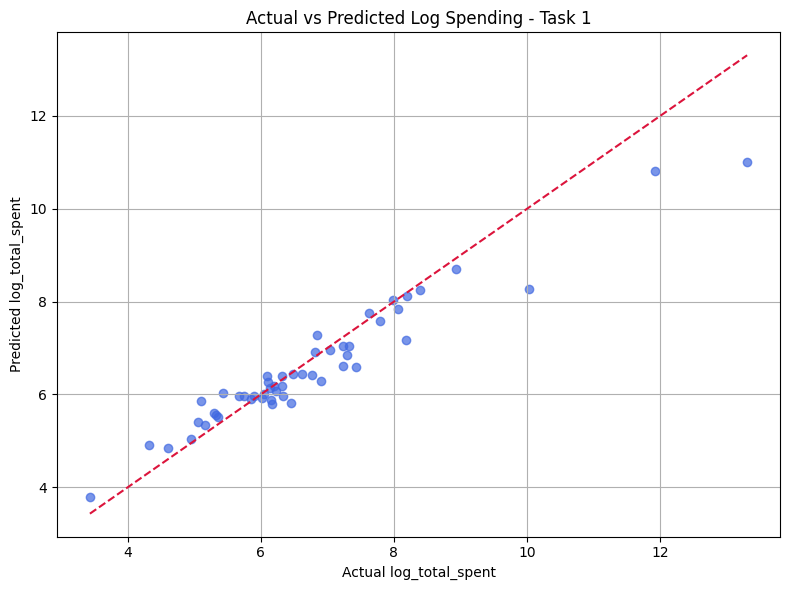

In [112]:
# === SCATTER PLOT Task 1 ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='crimson')
plt.title("Actual vs Predicted Log Spending - Task 1")
plt.xlabel("Actual log_total_spent")
plt.ylabel("Predicted log_total_spent")
plt.grid(True)
plt.tight_layout()
plt.show()

#This scatter plot visualizes how well the regression model predicts log-transformed spending.

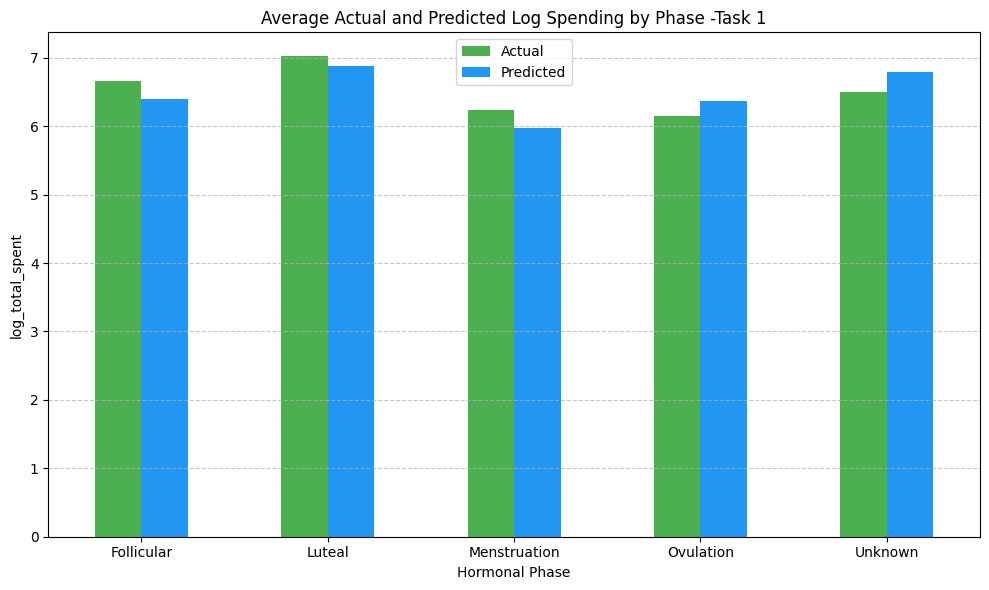

In [113]:
# === TASK 1- BAR PLOT: AVERAGE ACTUAL vs PREDICTED by PHASE ===
df_eval = X_test.copy()
df_eval["Actual"] = y_test
df_eval["Predicted"] = y_pred
df_eval["phase"] = df.loc[y_test.index, "phase"]

avg_phase = df_eval.groupby("phase")[["Actual", "Predicted"]].mean()
avg_phase.plot(kind='bar', figsize=(10, 6), color=['#4CAF50', '#2196F3'])
plt.title("Average Actual and Predicted Log Spending by Phase -Task 1")
plt.ylabel("log_total_spent")
plt.xlabel("Hormonal Phase")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

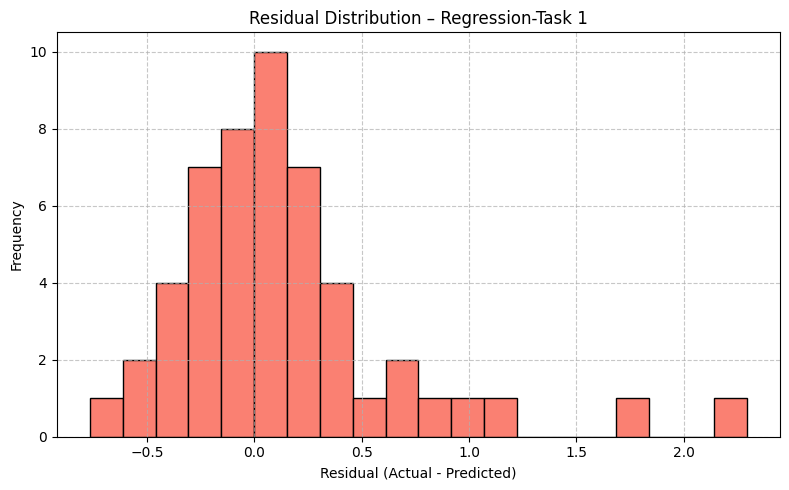

In [114]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, color='salmon', edgecolor='black')
plt.title("Residual Distribution – Regression-Task 1")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
#Helps explain class imbalance or overprediction.

<Figure size 1000x600 with 0 Axes>

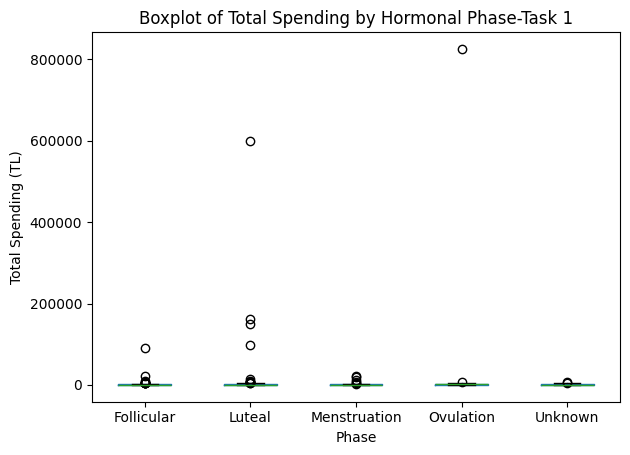

In [115]:
plt.figure(figsize=(10, 6))
df.boxplot(column="total_spent", by="phase", grid=False)
plt.title("Boxplot of Total Spending by Hormonal Phase-Task 1")
plt.suptitle("")
plt.xlabel("Phase")
plt.ylabel("Total Spending (TL)")
plt.tight_layout()
plt.show()


In [116]:
# === CLASSIFICATION TASK 2 ===
print("\n🎯 CLASSIFICATION: Predicting Hormonal Phase")

# Drop missing labels (safety check)
df = df.dropna(subset=["phase"])

# Define features and target
X_cls = df[classification_features]
y_cls = df["phase"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Pipeline with scaling and random forest classifier
pipeline_cls = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline_cls.fit(X_train, y_train)
y_pred_cls = pipeline_cls.predict(X_test)

# === Evaluation ===
print("🌸 Random Forest Classifier Results")
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred_cls), 3))
print("✅ F1 Score (weighted):", round(f1_score(y_test, y_pred_cls, average="weighted"), 3))

# === Classification Report ===
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_cls, digits=3))


🎯 CLASSIFICATION: Predicting Hormonal Phase
🌸 Random Forest Classifier Results
✅ Accuracy: 0.373
✅ F1 Score (weighted): 0.31

📊 Classification Report:
              precision    recall  f1-score   support

  Follicular      0.333     0.357     0.345        14
      Luteal      0.452     0.700     0.549        20
Menstruation      0.000     0.000     0.000         9
   Ovulation      0.000     0.000     0.000         3
     Unknown      0.000     0.000     0.000         5

    accuracy                          0.373        51
   macro avg      0.157     0.211     0.179        51
weighted avg      0.269     0.373     0.310        51



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Here trains a Random Forest Classifier to predict hormonal phase using daily spending features. While the model achieved 37.3% accuracy, it only performed well on the Luteal phase, struggling with others like Menstruation and Ovulation due to class imbalance and low sample size. Overall, the low F1-scores indicate the model has limited predictive power for this task.

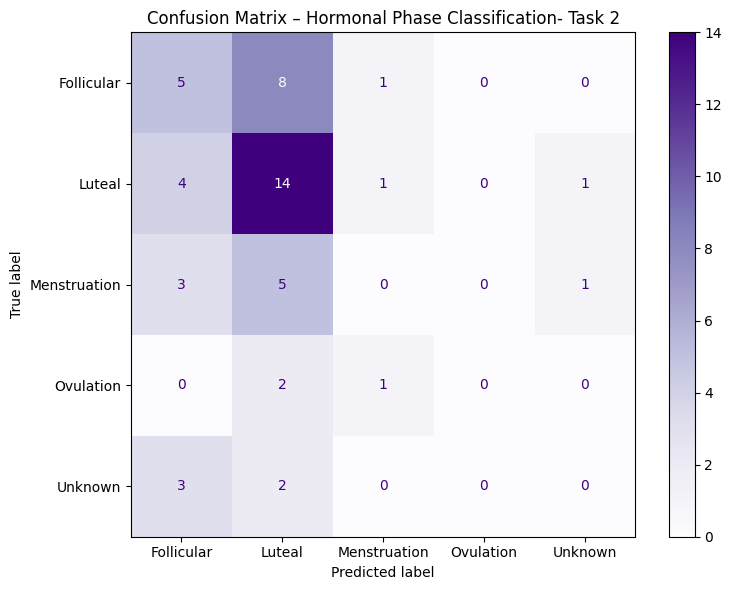

In [117]:
# === Confusion Matrix -Task 2 ===
labels = sorted(y_cls.unique())
cm = confusion_matrix(y_test, y_pred_cls, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Purples", values_format="d", ax=plt.gca())
plt.title("Confusion Matrix – Hormonal Phase Classification- Task 2")
plt.tight_layout()
plt.show()


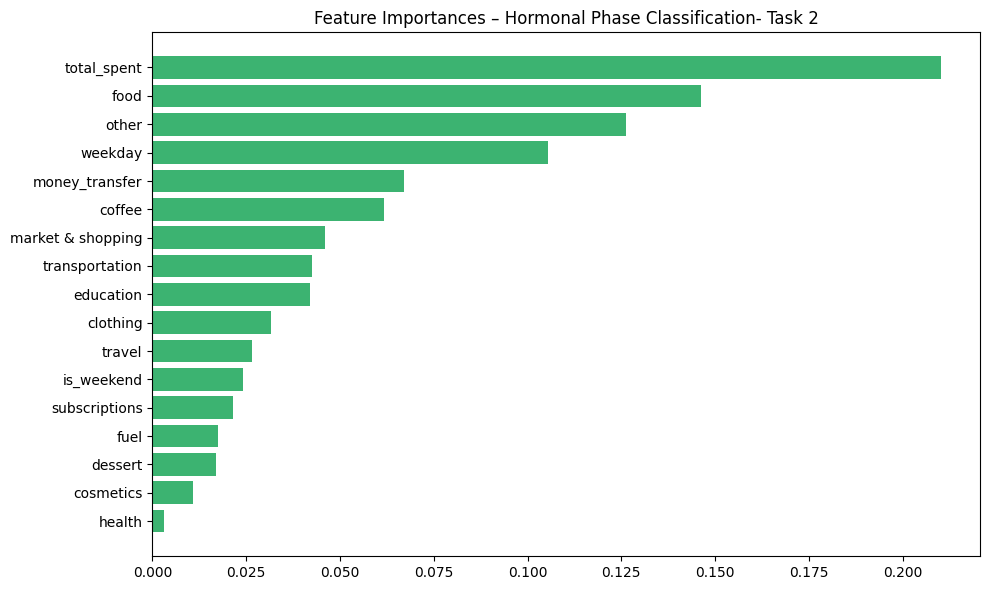

In [118]:
# === Feature Importance Plot ===
importances = pipeline_cls.named_steps["clf"].feature_importances_
feat_df = pd.DataFrame({
    "Feature": X_cls.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_df["Feature"], feat_df["Importance"], color="mediumseagreen")
plt.gca().invert_yaxis()
plt.title("Feature Importances – Hormonal Phase Classification- Task 2")
plt.tight_layout()
plt.show()


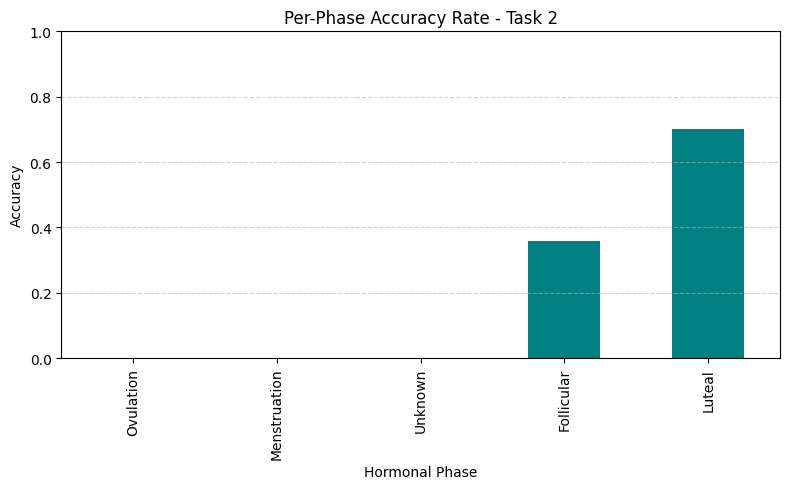

In [119]:
# === Phase-wise Misclassification Rate  ===
phase_errors = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_cls
})
phase_errors["Correct"] = phase_errors["Actual"] == phase_errors["Predicted"]
phase_accuracy = phase_errors.groupby("Actual")["Correct"].mean().sort_values()

plt.figure(figsize=(8, 5))
phase_accuracy.plot(kind="bar", color="teal")
plt.title("Per-Phase Accuracy Rate - Task 2")
plt.ylabel("Accuracy")
plt.xlabel("Hormonal Phase")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


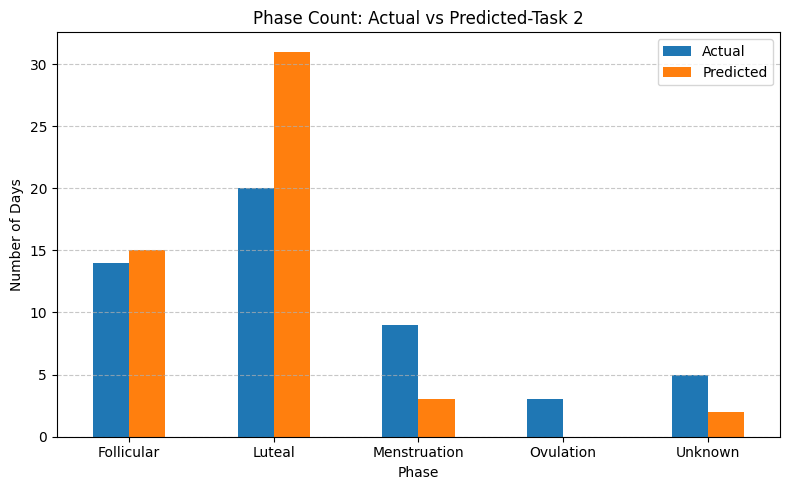

In [120]:
counts = pd.DataFrame({
    "Actual": y_test.value_counts().sort_index(),
    "Predicted": pd.Series(y_pred_cls).value_counts().sort_index()
})
counts.plot(kind="bar", figsize=(8, 5))
plt.title("Phase Count: Actual vs Predicted-Task 2")
plt.ylabel("Number of Days")
plt.xlabel("Phase")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
